C:\Users\12822\AppData\Local\Temp\ipykernel_53848\4210331158.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


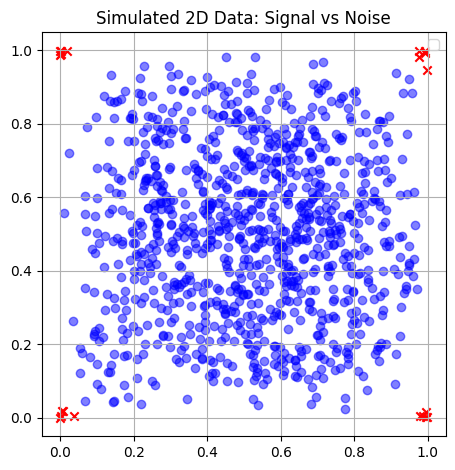

C:\Users\12822\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5070 Ti Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


[ready] X: (1000, 2), device=cuda:0, dtype=torch.float32; signal=980, noise1=5, noise2=5, noise3=5, noise4=5


In [1]:
# Cell 1: Initialize dataset X and plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import torch

# --- Parameters ---
N = 1000               # Total number of samples
n_noise = 5           # Number of noise samples per corner
n_signal = N - 4 * n_noise
p = 2
np.random.seed(0)    # Reproducibility

# --- Signal from Beta(p,p) x Beta(p,p) ---
signal = np.column_stack((
    beta.rvs(p, p, size=n_signal),
    beta.rvs(p, p, size=n_signal)
))

# --- Noise cluster 1 ---
noise1 = np.column_stack((
    beta.rvs(1, 100, size=n_noise),
    beta.rvs(1, 100, size=n_noise)
))

# --- Noise cluster 2 ---
noise2 = np.column_stack((
    beta.rvs(1, 100, size=n_noise),
    beta.rvs(100, 1, size=n_noise)
))

# --- Noise cluster 3 ---
noise3 = np.column_stack((
    beta.rvs(100, 1, size=n_noise),
    beta.rvs(1, 100, size=n_noise)
))

# --- Noise cluster 4 ---
noise4 = np.column_stack((
    beta.rvs(100, 1, size=n_noise),
    beta.rvs(100, 1, size=n_noise)
))

# --- Combine and arrange ---
X_data = np.vstack([noise1,noise2, signal, noise3, noise4])
noise1_idx = np.arange(0, n_noise)
noise2_idx = np.arange(n_noise, 2 * n_noise)
signal_idx = np.arange(2 * n_noise, n_signal + 2 * n_noise)
noise3_idx = np.arange(n_signal + 2 * n_noise, n_signal + 3 * n_noise)
noise4_idx = np.arange(n_signal + 3 * n_noise, N)


# --- Plot ---
plt.scatter(X_data[signal_idx, 0], X_data[signal_idx, 1], color='blue', alpha=0.5)
plt.scatter(X_data[noise1_idx, 0], X_data[noise1_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise2_idx, 0], X_data[noise2_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise3_idx, 0], X_data[noise3_idx, 1], color='red', marker='x')
plt.scatter(X_data[noise4_idx, 0], X_data[noise4_idx, 1], color='red', marker='x')
plt.legend()
plt.grid(True)
plt.title("Simulated 2D Data: Signal vs Noise")
plt.axis('square')
plt.tight_layout()
plt.show()

# ---------------------- Below: make dataset ready for later usage ----------------------
# (No changes to the original content above.)
_mps_ok = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if _mps_ok else "cpu"))
X = torch.tensor(X_data, dtype=torch.get_default_dtype(), device=device)
M = X.shape[0]

# Boolean masks as tensors (useful for later diagnostics/plots)
signal_mask = torch.zeros(M, dtype=torch.bool, device=device); signal_mask[signal_idx] = True
noise1_mask = torch.zeros(M, dtype=torch.bool, device=device); noise1_mask[noise1_idx] = True
noise2_mask = torch.zeros(M, dtype=torch.bool, device=device); noise2_mask[noise2_idx] = True
noise3_mask = torch.zeros(M, dtype=torch.bool, device=device); noise3_mask[noise3_idx] = True
noise4_mask = torch.zeros(M, dtype=torch.bool, device=device); noise4_mask[noise4_idx] = True

# Bounds often needed for grids/visualization
x_min, y_min = X_data.min(axis=0).astype(float)
x_max, y_max = X_data.max(axis=0).astype(float)

# Small bundle for convenience
dataset = {
    "X": X,
    "M": M,
    "idx_np": {"signal": signal_idx, "noise1": noise1_idx, "noise2": noise2_idx, "noise3": noise3_idx, "noise4": noise4_idx},
    "mask_t": {"signal": signal_mask, "noise1": noise1_mask, "noise2": noise2_mask, "noise3": noise3_mask, "noise4": noise4_mask},
    "bounds": (float(x_min), float(x_max), float(y_min), float(y_max)),
    "device": str(device),
}

print(f"[ready] X: {tuple(X.shape)}, device={X.device}, dtype={X.dtype}; "
        f"signal={signal_mask.sum().item()}, noise1={noise1_mask.sum().item()}, "
        f"noise2={noise2_mask.sum().item()}, noise3={noise3_mask.sum().item()}, "
        f"noise4={noise4_mask.sum().item()}")


In [2]:
from torch import nn

class CriticNet(nn.Module):
    def __init__(self, d_in=2, hidden=(256, 256), neg_slope=0.2, dropout=0.0):
        """
        Minimal critic for WGAN-GP.
        - d_in: input dimension (2 for your Beta×Beta toy data)
        - hidden: tuple of hidden layer sizes
        - neg_slope: LeakyReLU slope
        - dropout: optional, usually 0.0 for critic
        """
        super().__init__()
        layers = []
        last = d_in
        for h in hidden:
            layers += [nn.Linear(last, h), nn.LeakyReLU(neg_slope)]
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            last = h
        layers += [nn.Linear(last, 1)]  # scalar output
        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=0.2, nonlinearity='leaky_relu')
            nn.init.zeros_(m.bias)


    def forward(self, x):
        # returns shape [B] (so .reshape(-1) in your code is safe)
        return self.net(x).squeeze(-1)


In [3]:
from torch.distributions import Beta as TorchBeta
torch.manual_seed(0)
p_theta = 2

def make_beta_prod_sampler(p: float, device=None, dtype=None):
    device = device or X.device
    dtype  = dtype  or X.dtype
    conc   = torch.full((2,), float(p), device=device, dtype=dtype)  # [2] -> (alpha,beta) for each dim
    dist   = TorchBeta(conc, conc)  # independent across dims via batch shape (2,)
    def sample(m: int):
        return dist.rsample((m,)) if getattr(dist, "has_rsample", False) else dist.sample((m,))
    return sample

sample_F_theta = make_beta_prod_sampler(p_theta)


In [4]:
def build_minibatch_data(X, w, sample_F_theta, real_bs, fake_bs, *, replace=True):
    """
    Data+Sampling for critic training (θ fixed, w fixed).

    Inputs
    ------
    X : torch.Tensor [N, d]
        Observed samples on device.
    w : torch.Tensor [N]
        Current weights over X (need not be perfectly normalized).
    sample_F_theta : callable
        Function taking an integer m and returning m samples from F_θ as a tensor [m, d].
    real_bs : int
        Number of real samples to draw (weighted by w).
    fake_bs : int
        Number of fake samples to draw from F_θ.
    replace : bool, default True
        Whether to sample real indices with replacement.

    Returns
    -------
    X_real : torch.Tensor [real_bs, d]
        Real minibatch sampled according to w.
    w_batch : torch.Tensor [real_bs]
        Renormalized weights corresponding to X_real (sum to 1).
    Z_fake : torch.Tensor [fake_bs, d]
        Fake minibatch sampled from F_θ.
    idx_real : torch.Tensor [real_bs]
        Indices of the selected real samples in X.
    """
    device = X.device
    dtype  = X.dtype
    N = X.shape[0]

    # --- sanitize weights to simplex on the fly ---
    w = w.to(device=device, dtype=dtype).flatten()
    w = torch.clamp(w, min=0)
    s = w.sum()
    w = (torch.ones_like(w) / N) if s <= 0 else (w / s)

    # --- sample real indices by weights ---
    idx_real = torch.multinomial(w, num_samples=real_bs, replacement=replace)

    # --- gather real batch and renormalize batch-weights ---
    X_real = X.index_select(0, idx_real)
    w_batch = w.index_select(0, idx_real)
    w_sum = w_batch.sum()
    w_batch = (torch.ones_like(w_batch) / w_batch.numel()) if w_sum <= 0 else (w_batch / w_sum)

    # --- sample fake from F and align device/dtype ---
    Z_fake = sample_F_theta(fake_bs).to(device=device, dtype=dtype)

    return X_real, w_batch, Z_fake, idx_real


In [5]:
def critic_forward_objective(
    phi,
    X_real,          # [B_r, d] real minibatch (sampled by w)
    w_batch,         # [B_r]    weights corresponding to X_real (should sum to 1)
    Z_fake,          # [B_f, d] fake minibatch ~ F_θ
    *,
    gp_lambda: float = 0.0,   # >0 to apply WGAN-GP; 0.0 disables it
    gp_center: float = 1.0    # target gradient norm (usually 1.0)
):
    """
    Compute the critic objective (no optimizer step):
      J(φ; w) = E_{X~Q}[f_φ(X)] - E_{Z~F_θ}[f_φ(Z)]
    and (optionally) add WGAN-GP to the minimization loss:
      loss = -J + λ_gp * E[(||∇_x f_φ(Ẋ)||_2 - gp_center)^2]

    Returns:
      loss : tensor scalar suitable for loss.backward()
      J    : tensor scalar (maximize this)
      stats: dict of detached scalars for logging
    """
    # --- device/dtype alignment ---
    device = X_real.device
    dtype  = X_real.dtype
    w_batch = w_batch.to(device=device, dtype=dtype)
    Z_fake  = Z_fake.to(device=device, dtype=dtype)

    # --- ensure weights sum to 1 on the batch (defensive) ---
    w_sum = w_batch.sum()
    if not torch.isfinite(w_sum) or w_sum.item() <= 0:
        w_batch = torch.ones_like(w_batch) / w_batch.numel()
    else:
        w_batch = w_batch / w_sum

    # --- critic scores ---
    real_scores = phi(X_real).reshape(-1)      # [B_r]
    fake_scores = phi(Z_fake).reshape(-1)      # [B_f]

    real_term   = real_scores.mean()
    fake_term = fake_scores.mean()             # plain mean over fake
    J = real_term - fake_term                  # maximize J

    # --- base loss: minimize -J ---
    loss = -J

    # --- optional gradient penalty (WGAN-GP) ---
    gp = torch.tensor(0.0, device=device, dtype=dtype)
    if gp_lambda > 0.0:
        br = X_real.shape[0]
        # sample interpolation coefficients
        eps = torch.rand(br, 1, device=device, dtype=dtype)
        # match shapes for broadcast
        if Z_fake.shape[0] < br:
            # if fewer fakes than reals, tile fakes (simple, OK for objective forward)
            reps = (br + Z_fake.shape[0] - 1) // Z_fake.shape[0]
            Z_fake_expand = Z_fake.repeat(reps, 1)[:br]
        else:
            Z_fake_expand = Z_fake[:br]
        x_hat = eps * X_real + (1 - eps) * Z_fake_expand
        x_hat.requires_grad_(True)

        # score on interpolates
        f_hat = phi(x_hat).reshape(-1)  # [br]
        # gradients wrt inputs
        grad_outputs = torch.ones_like(f_hat)
        grads = torch.autograd.grad(
            outputs=f_hat, inputs=x_hat, grad_outputs=grad_outputs,
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]  # [br, d]

        grad_norm = grads.norm(2, dim=1)                  # [br]
        gp = ((grad_norm - gp_center) ** 2).mean()        # scalar
        loss = loss + gp_lambda * gp

    # --- stats for logging ---
    stats = {
        "J":       float(J.detach().cpu()),
        "real":    float(real_term.detach().cpu()),
        "fake":    float(fake_term.detach().cpu()),
        "gp":      float(gp.detach().cpu()),
        "real_mu": float(real_scores.detach().mean().cpu()),
        "real_sd": float(real_scores.detach().std(unbiased=False).cpu()),
        "fake_mu": float(fake_scores.detach().mean().cpu()),
        "fake_sd": float(fake_scores.detach().std(unbiased=False).cpu()),
    }
    return loss, J, stats


In [6]:
def lipschitz_control_wgan_gp(
    phi,
    X_real,          # [B_r, d]
    Z_fake,          # [B_f, d]
    *,
    gp_lambda: float = 10.0,
    gp_center: float = 1.0,
):
    """
    Recommended Lipschitz control: WGAN-GP.
    Computes the gradient penalty term:
        gp_lambda * E[(||∇_x f_phi(x_hat)||_2 - gp_center)^2]
    where x_hat is a random interpolation between real and fake.

    Returns:
      penalty : scalar tensor (add to your loss)
      stats   : dict with detached floats for logging
    """
    device, dtype = X_real.device, X_real.dtype
    br = X_real.shape[0]
    Z_fake = Z_fake.to(device=device, dtype=dtype)

    # Match batch sizes (tile fakes if needed)
    if Z_fake.shape[0] < br:
        reps = (br + Z_fake.shape[0] - 1) // Z_fake.shape[0]
        Zf = Z_fake.repeat(reps, 1)[:br]
    else:
        Zf = Z_fake[:br]

    # Interpolate between real and fake
    eps = torch.rand(br, 1, device=device, dtype=dtype)
    x_hat = eps * X_real + (1.0 - eps) * Zf
    x_hat.requires_grad_(True)

    # Critic on interpolates
    f_hat = phi(x_hat).reshape(-1)
    grad_outputs = torch.ones_like(f_hat)

    # Gradients w.r.t. inputs
    grads = torch.autograd.grad(
        outputs=f_hat, inputs=x_hat, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]  # [br, d]

    grad_norm = grads.norm(2, dim=1)
    penalty = gp_lambda * ((grad_norm - gp_center) ** 2).mean()

    stats = {
        "gp": float(penalty.detach().cpu()),
        "grad_norm_mean": float(grad_norm.detach().mean().cpu()),
        "grad_norm_std": float(grad_norm.detach().std(unbiased=False).cpu()),
    }
    return penalty, stats


In [7]:
def optimizer_plumbing_step(
    loss,
    optimizer,
    module=None,
    *,
    use_amp: bool = False,
    scaler: torch.cuda.amp.GradScaler | None = None,
    max_grad_norm: float | None = None,
    weight_clip_value: float | None = None,
):
    """
    One-shot optimizer plumbing:
      - zero grad
      - (AMP) backward
      - (optional) grad clipping
      - optimizer step
      - (optional) weight clipping

    Parameters
    ----------
    loss : torch.Tensor (scalar)
        The loss to backpropagate.
    optimizer : torch.optim.Optimizer
        Optimizer to step.
    module : torch.nn.Module | None
        If provided and weight_clip_value is not None, clip params of this module after step.
    use_amp : bool
        Use automatic mixed precision (AMP).
    scaler : torch.cuda.amp.GradScaler | None
        GradScaler to use when use_amp=True. If None, a new one is created.
    max_grad_norm : float | None
        If set, clip gradient norm to this value.
    weight_clip_value : float | None
        If set and module is provided, clamp parameters to [-value, value] after step.

    Returns
    -------
    stats : dict
        {
          "loss": float,
          "grad_norm": float | None
        }
    """
    optimizer.zero_grad(set_to_none=True)

    grad_norm_value = None

    if use_amp:
        from torch import amp
        scaler = scaler or amp.GradScaler(enabled=True)
        scaler.scale(loss).backward()
        if max_grad_norm is not None:
            scaler.unscale_(optimizer)
            grad_norm_value = float(torch.nn.utils.clip_grad_norm_(module.parameters(), max_grad_norm).detach().cpu()) \
                              if module is not None else None
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        if max_grad_norm is not None:
            grad_norm_value = float(torch.nn.utils.clip_grad_norm_(module.parameters(), max_grad_norm).detach().cpu()) \
                              if module is not None else None
        optimizer.step()

    if (weight_clip_value is not None) and (module is not None):
        for p in module.parameters():
            if p is not None:
                p.data.clamp_(-weight_clip_value, weight_clip_value)

    return {"loss": float(loss.detach().cpu()), "grad_norm": grad_norm_value}


In [8]:
def monitor_critic_training_step(
    step: int,
    stats: dict,                    # e.g., from critic_forward_objective / critic_objective_fixed_w: {"J","H","L","gp","real","fake","g_mean","g_std",...}
    history: list,                  # mutable list to store per-step records (append-only)
    state: dict | None = None,      # mutable state carried across calls; can be None on first call
    *,
    opt_stats: dict | None = None,  # e.g., from optimizer_plumbing_step: {"loss","grad_norm"}
    log_every: int = 10,
    ema_keys: tuple[str, ...] = ("J", "loss"),  # which keys to maintain EMA for (if present)
    ema_beta: float = 0.9,          # EMA decay (higher = smoother)
    early_stop_key: str = "J",      # metric to monitor for early stopping (maximize)
    early_stop_window: int = 40,    # steps per window
    early_stop_tol: float = 5e-5,   # relative improvement threshold across consecutive windows
    print_fn=None                   # custom logger; defaults to built-in print
):
    """
    One-stop monitoring utility:
      - merges stats and opt_stats
      - appends a per-step record to history
      - maintains EMA for selected keys in 'state'
      - checks early stopping via windowed best-improvement on early_stop_key
      - prints concise logs every 'log_every' steps

    Returns:
      early_stop (bool), state (dict)
    """
    if print_fn is None:
        print_fn = print

    # --- init state ---
    if state is None or not isinstance(state, dict):
        state = {"ema": {}, "nonfinite_count": 0}

    # --- combine stats ---
    record = {"step": int(step)}
    if stats:
        for k, v in stats.items():
            # accept torch/scalar/float; coerce to float if possible
            try:
                record[k] = float(v)
            except Exception:
                record[k] = v
    if opt_stats:
        for k, v in opt_stats.items():
            try:
                record[k] = float(v)
            except Exception:
                record[k] = v

    # --- non-finite guard ---
    nonfinite_keys = []
    for k, v in list(record.items()):
        if isinstance(v, float) and (v != v or v == float("inf") or v == float("-inf")):  # NaN/Inf check
            nonfinite_keys.append(k)
    if nonfinite_keys:
        state["nonfinite_count"] = state.get("nonfinite_count", 0) + 1
        # replace non-finite with last finite value if available, otherwise zero
        if history:
            last = history[-1]
            for k in nonfinite_keys:
                record[k] = last.get(k, 0.0)
        else:
            for k in nonfinite_keys:
                record[k] = 0.0

    # --- update EMAs for selected keys (only if present) ---
    for k in ema_keys:
        if k in record and isinstance(record[k], float):
            prev = state["ema"].get(k, record[k])
            state["ema"][k] = ema_beta * prev + (1.0 - ema_beta) * record[k]
            record[f"ema_{k}"] = state["ema"][k]

    # --- append to history ---
    history.append(record)

    # --- early stopping: compare windowed bests of early_stop_key ---
    early_stop = False
    if early_stop_key in record and isinstance(record[early_stop_key], float):
        n = len(history)
        if n >= 2 * early_stop_window:
            # previous window: [n-2w, n-w), recent window: [n-w, n)
            prev_best = max(h.get(early_stop_key, float("-inf")) for h in history[n - 2 * early_stop_window : n - early_stop_window])
            recent_best = max(h.get(early_stop_key, float("-inf")) for h in history[n - early_stop_window : n])
            # relative improvement
            denom = max(1.0, abs(prev_best))
            rel_improve = (recent_best - prev_best) / denom
            record["recent_best"] = recent_best
            record["prev_best"] = prev_best
            record["rel_improve"] = rel_improve
            early_stop = rel_improve < early_stop_tol

    # --- periodic logging ---
    if (log_every is not None) and (step % log_every == 0):
        parts = [f"[critic] step {step:5d}"]
        for k in ("J", "H", "L", "gp", "loss", "grad_norm"):
            if k in record and isinstance(record[k], float):
                parts.append(f"{k}={record[k]:.6f}")
        for k in ema_keys:
            kk = f"ema_{k}"
            if kk in record and isinstance(record[kk], float):
                parts.append(f"{kk}={record[kk]:.6f}")
        if "rel_improve" in record:
            parts.append(f"Δ_rel={record['rel_improve']:.3e}")
        print_fn("  ".join(parts))

    return early_stop, state


In [9]:
def critic_update(
    step: int,
    *,
    phi,                         # critic nn.Module
    optimizer,                   # torch.optim.Optimizer for phi
    X,                           # [N, d] data tensor (device/dtype set)
    w,                           # [N]    current weights over X (any scale; will be renormalized in sampler)
    sample_F_theta,              # callable(m) -> [m, d] samples from fixed F_θ
    real_bs: int,
    fake_bs: int,
    gp_lambda: float = 10.0,     # WGAN-GP (set <=0 to disable)
    gp_center: float = 1.0,
    use_amp: bool = False,
    scaler=None,                 # AMP GradScaler (optional)
    max_grad_norm: float | None = None,
    weight_clip_value: float | None = None,  # typically None when using GP
    history: list | None = None,             # pass a list to accumulate logs
    state: dict | None = None,               # monitoring state (EMA / early-stop), pass back each call
    log_every: int = 10,
    print_fn=None
):
    """
    One training iteration for the critic with fixed θ and current weights w.

    Pipeline:
      1) Build a minibatch: X_real ~ Q (via weighted sampling by w), Z_fake ~ F_θ
      2) Forward critic objective J = E_Q[f] - E_{F_θ}[f]  (no penalty)
      3) Lipschitz control via WGAN-GP (optional)
      4) Backprop + optimizer step (AMP/clip/weight-clip as configured)
      5) Monitoring/logging (+ early-stop heuristic)

    Returns:
      record : dict   (merged stats for this step)
      early_stop : bool
      state : dict    (updated monitoring state; pass it back to the next call)
      idx_real : tensor  (indices of real samples drawn this step)
    """
    # 1) data + sampling
    X_real, w_batch, Z_fake, idx_real = build_minibatch_data(
        X, w, sample_F_theta, real_bs, fake_bs, replace=True
    )

    # 2) base objective (without GP)
    base_loss, J, obj_stats = critic_forward_objective(
        phi, X_real, w_batch, Z_fake, gp_lambda=0.0
    )

    # 3) Lipschitz control (WGAN-GP)
    gp_term = 0.0
    gp_stats = {}
    if gp_lambda and gp_lambda > 0.0:
        penalty, gp_stats = lipschitz_control_wgan_gp(
            phi, X_real, Z_fake, gp_lambda=gp_lambda, gp_center=gp_center
        )
        loss_total = base_loss + penalty
        gp_term = gp_stats.get("gp", float(penalty.detach().cpu()))
    else:
        loss_total = base_loss

    # 4) optimizer plumbing
    opt_stats = optimizer_plumbing_step(
        loss_total,
        optimizer,
        module=phi,
        use_amp=use_amp,
        scaler=scaler,
        max_grad_norm=max_grad_norm,
        weight_clip_value=weight_clip_value,
    )

    # 5) monitoring/logging
    merged_stats = {}
    merged_stats.update(obj_stats)           # J, real, fake, etc.
    if gp_lambda and gp_lambda > 0.0:
        merged_stats.update({"gp": gp_term})
        # include raw gp diagnostics if available
        for k in ("grad_norm_mean", "grad_norm_std"):
            if k in gp_stats:
                merged_stats[k] = gp_stats[k]

    early_stop, state = monitor_critic_training_step(
        step=step,
        stats=merged_stats,
        history=(history if history is not None else []),
        state=state,
        opt_stats=opt_stats,
        log_every=log_every,
        ema_keys=("J", "loss"),
        ema_beta=0.9,
        early_stop_key="J",
        early_stop_window=40,
        early_stop_tol=5e-5,
        print_fn=print_fn
    )

    # package a compact record for convenience
    record = {"step": step}
    record.update(merged_stats)
    record.update(opt_stats)

    return record, early_stop, state, idx_real


In [10]:
@torch.no_grad()
def weights_update(self, X=None, lam=None, eps_mix=1e-3):
    """
    Closed-form ETEL weight update with WGAN critic:
        w ∝ exp(-λ * f_phi(X))  i.e.  w = softmax(-λ * f_phi(X))
    Optionally mix with uniform by eps_mix to avoid degeneracy.
    """
    x = X if X is not None else self.X                    # [n, d]
    lam = float(lam if lam is not None else self.lambda_w)
    
    f = self.phi(x).flatten().detach()                    # [n]
    f_nrm = (f - f.mean()) / (f.std(unbiased=False).clamp_min(1e-8))
    f_nrm = f_nrm.clamp(-3.0, 3.0)
    logits = -lam * f_nrm
    logits = logits - logits.max()                        # numerical stability
    w = torch.softmax(logits, dim=0)                      # [n]

    if eps_mix and eps_mix > 0:
        n = w.numel()
        w = (1.0 - eps_mix) * w + eps_mix / n

    w = w / w.sum()                                       # exact simplex
    if not torch.isfinite(w).all():                       # safety fallback
        n = x.shape[0]
        w = torch.full((n,), 1.0 / n, device=x.device, dtype=x.dtype)

    self.w = w                                            # store (buffer, not Parameter)
    return w


In [11]:
# @torch.no_grad()
# def weights_update(self, X=None, lam=None, eps_mix=1e-3, prior=None, cap_mult=10):
#     """
#     Prior-aware ETEL update with capped-simplex projection:
#         w* = argmin_w  KL(w || prior) + lam * <w, f_phi(X)>
#       => w ∝ prior * exp(-lam * f)
#     Then project to { w ≥ 0, sum w = 1, w_i ≤ cap_mult/N } and mix a tiny uniform mass.
#     """
#     x = X if X is not None else self.X
#     lam = float(lam if lam is not None else getattr(self, "lambda_w", 5.0))
#     n  = x.shape[0]
#     device, dtype = x.device, x.dtype

#     # baseline prior (uniform if not provided)
#     if prior is None:
#         prior = torch.full((n,), 1.0/n, device=device, dtype=dtype)
#     else:
#         prior = prior.to(device=device, dtype=dtype)
#         prior = torch.clamp(prior, min=0)
#         prior = prior / prior.sum().clamp_min(1e-12)

#     # critic scores
#     f = self.phi(x).flatten().detach()

#     # prior-aware softmax in log-domain
#     log_prior = torch.log(prior.clamp_min(1e-12))
#     logits = log_prior - lam * f
#     logits = logits - logits.max()                   # stability
#     w = torch.softmax(logits, dim=0)

#     # tiny uniform mix to avoid degeneracy
#     if eps_mix and eps_mix > 0:
#         w = (1.0 - eps_mix) * w + eps_mix / n

#     # --- project to capped simplex: w_i ≤ cap_mult/N ---
#     cap = float(cap_mult) / n
#     for _ in range(10):  # water-filling iterations (usually converges in 2–3)
#         over = w > cap
#         excess = (w[over] - cap).sum()
#         if excess <= 1e-12:
#             break
#         w[over] = cap
#         under = ~over
#         if under.any():
#             w[under] += excess * (w[under] / w[under].sum().clamp_min(1e-12))
#         else:
#             # extreme corner case: everyone clamped -> go uniform
#             w = torch.full((n,), 1.0/n, device=device, dtype=dtype)
#             break

#     w = w / w.sum().clamp_min(1e-12)
#     if not torch.isfinite(w).all():
#         w = torch.full((n,), 1.0/n, device=device, dtype=dtype)

#     self.w = w
#     return w


In [12]:
# ===== Minimal main loop (init once, then call helpers) =====
import torch
from types import SimpleNamespace

# --- hyperparams (tweak as needed) ---
T_outer       = 1000          # outer rounds
C_per_round   = 30            # critic steps per round
real_bs       = 512
fake_bs       = 2048
gp_lambda     = 10.0
gp_center     = 1.0
lambda_w      = 4         # ETEL temperature
eps_mix       = 2e-4
use_amp       = (X.device.type == "cuda")

# --- critic & optimizer ---
phi = CriticNet(d_in=2, hidden=(256, 256)).to(X.device)
opt = torch.optim.Adam(phi.parameters(), lr=3e-4, betas=(0.5, 0.9))

# --- weights (uniform start) ---
w0 = torch.full((M,), 1.0 / M, device=X.device, dtype=X.dtype)

# bind your "method" weights_update(self, ...) by giving it a simple context
ctx = SimpleNamespace(phi=phi, X=X, lambda_w=lambda_w, w=w0)

history, state = [], None
step = 0

for t in range(1, T_outer + 1):
    # (1) critic updates with current weights
    early = False
    for _ in range(C_per_round):
        step += 1
        _, early, state, _ = critic_update(
            step=step,
            phi=phi, optimizer=opt,
            X=X, w=ctx.w,
            sample_F_theta=sample_F_theta,
            real_bs=real_bs, fake_bs=fake_bs,
            gp_lambda=gp_lambda, gp_center=gp_center,
            use_amp=use_amp, scaler=None,
            history=history, state=state,
            log_every=100,                  # silent; set to 20 for logs
            print_fn=None
        )
        early=False
        if early:
            print("[early]", state)
            break

    # (2) ETEL weight update (your provided method)
    weights_update(ctx, eps_mix=eps_mix)     # updates ctx.w in-place

    # (3) tiny heartbeat every 10 rounds
    if t % 100 == 0 or t == 1:
        with torch.no_grad():
            H = float((-(ctx.w * ctx.w.clamp_min(1e-12).log())).sum().cpu())
            print(f"[round {t:03d}] H(w)={H:.4f}  w[min,max]=({ctx.w.min().item():.2e}, {ctx.w.max().item():.2e})")
    if early:
        print(f"Early stop at round {t}.")
        break

# expose results
trained = {
    "phi": phi,
    "optimizer": opt,
    "w": ctx.w,
    "lambda_w": lambda_w,
    "gp_lambda": gp_lambda,
    "history": history,
    "state": state,
}


C:\Users\12822\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[round 001] H(w)=2.9977  w[min,max]=(2.00e-07, 1.74e-01)
[critic] step   100  J=-0.334024  gp=0.176217  loss=0.510242  ema_J=-0.390477  ema_loss=0.476466  Δ_rel=-2.323e-01
[critic] step   200  J=-0.065412  gp=0.150972  loss=0.216384  ema_J=-0.117720  ema_loss=0.348467  Δ_rel=-1.101e-01
[critic] step   300  J=0.338647  gp=0.899484  loss=0.560837  ema_J=0.152258  ema_loss=0.156844  Δ_rel=2.540e-01
[critic] step   400  J=-0.098471  gp=0.171780  loss=0.270250  ema_J=-0.104169  ema_loss=0.333283  Δ_rel=6.145e-01
[critic] step   500  J=-0.428344  gp=0.144617  loss=0.572961  ema_J=-0.373775  ema_loss=0.500042  Δ_rel=-2.586e-01
[critic] step   600  J=0.322559  gp=0.170836  loss=-0.151723  ema_J=0.100927  ema_loss=0.067712  Δ_rel=5.196e-01
[critic] step   700  J=-0.179286  gp=0.121958  loss=0.301244  ema_J=-0.254324  ema_loss=0.443883  Δ_rel=-4.997e-01
[critic] step   800  J=-0.252416  gp=0.111894  loss=0.364310  ema_J=-0.287834  ema_loss=0.418373  Δ_rel=1.932e-02
[critic] step   900  J=0.00143

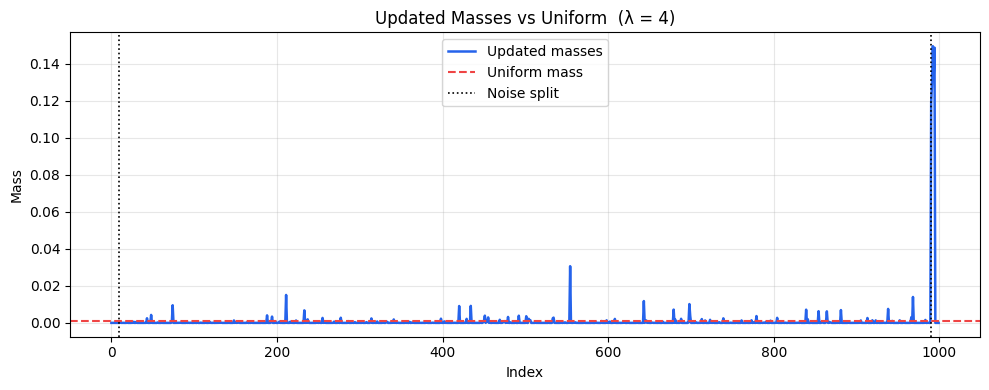

In [13]:
# ===== Plot updated masses vs uniform (with noise index markers) =====
import numpy as np
import matplotlib.pyplot as plt
import torch

# pull weights & lambda
w_t = trained["w"]
w_np = w_t.detach().cpu().numpy() if isinstance(w_t, torch.Tensor) else np.asarray(w_t)
N = w_np.size
uniform_mass = 1.0 / N
lam_disp = float(trained.get("lambda_w", 0.0))

# noise boundaries from how X_data was stacked
n_signal = len(dataset["idx_np"]["signal"])
n_noise  = len(dataset["idx_np"]["noise1"])
i_noise1_end = 2 * n_noise
i_noise2_start = n_signal + 2 * n_noise

# plot
x = np.arange(N)
plt.figure(figsize=(10,4))
plt.plot(x, w_np, lw=1.8, color="#2563eb", label="Updated masses")
plt.axhline(uniform_mass, color="#ef4444", ls="--", lw=1.5, label="Uniform mass")
plt.axvline(i_noise1_end-0.5, color="k", ls=":", lw=1.2, label="Noise split")
plt.axvline(i_noise2_start-0.5, color="k", ls=":", lw=1.2)

plt.title(f"Updated Masses vs Uniform  (λ = {lam_disp:g})")
plt.xlabel("Index")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
with torch.no_grad():
    groups = dataset["mask_t"]
    counts = {k:int(m.sum().item()) for k,m in groups.items()}
    coord_means = {k: tuple(X[m].mean(0).tolist()) for k,m in groups.items()}
    print("counts:", counts)
    print("coord means ~ corner centers:", coord_means)  # expect: noise1≈(0,0), noise2≈(0,1), noise3≈(1,0), noise4≈(1,1)


counts: {'signal': 980, 'noise1': 5, 'noise2': 5, 'noise3': 5, 'noise4': 5}
coord means ~ corner centers: {'signal': (0.5137155652046204, 0.5005290508270264), 'noise1': (0.011144997552037239, 0.010218131355941296), 'noise2': (0.005027289502322674, 0.9935066103935242), 'noise3': (0.9905336499214172, 0.0057889134623110294), 'noise4': (0.9874405264854431, 0.9824774861335754)}


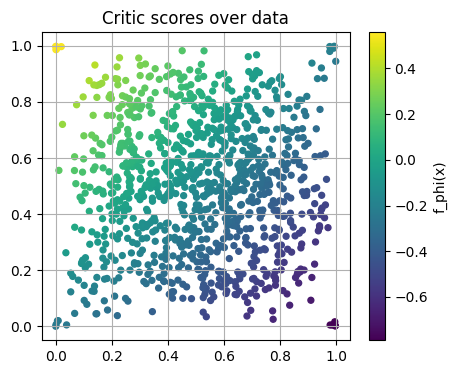

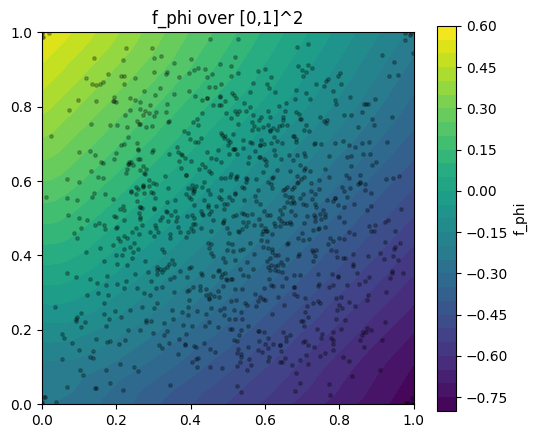

In [15]:
import matplotlib.pyplot as plt

with torch.no_grad():
    xy = X.detach().cpu().numpy()
    f_all = phi(X).flatten().detach().cpu().numpy()

plt.figure(figsize=(5,4))
sc = plt.scatter(xy[:,0], xy[:,1], c=f_all, s=18, cmap="viridis")
plt.colorbar(sc, label="f_phi(x)")
plt.title("Critic scores over data")
plt.grid(True); plt.gca().set_aspect("equal", "box"); plt.show()

def eval_phi_grid(phi, nx=120, ny=120, xmin=0, xmax=1, ymin=0, ymax=1):
    xs = torch.linspace(xmin, xmax, nx, device=X.device, dtype=X.dtype)
    ys = torch.linspace(ymin, ymax, ny, device=X.device, dtype=X.dtype)
    Xg, Yg = torch.meshgrid(xs, ys, indexing='xy')
    G = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
    with torch.no_grad():
        F = phi(G).reshape(nx, ny).cpu().numpy()
    return Xg.cpu().numpy(), Yg.cpu().numpy(), F

Xg, Yg, F = eval_phi_grid(phi)
plt.figure(figsize=(6,5))
cs = plt.contourf(Xg, Yg, F, levels=30)
plt.colorbar(cs, label="f_phi")
plt.scatter(xy[:,0], xy[:,1], s=6, c="k", alpha=0.25)
plt.title("f_phi over [0,1]^2"); plt.gca().set_aspect("equal","box"); plt.show()


In [16]:
for t in range(1, T_outer+1):
    # critic steps ...
    if t > 10:  # warmup first 10 rounds
        eps = 1e-2 if t <= 30 else 1e-3
        weights_update(ctx, eps_mix=eps)  # uses logits = -λ * f_nrm
    # diagnostics
    if t % 10 == 0 or t == 1:
        with torch.no_grad():
            masses = {k: float(ctx.w[m].sum().cpu()) for k,m in dataset["mask_t"].items()}
            print(f"[round {t:03d}] masses:", {k: round(v,4) for k,v in masses.items()})


[round 001] masses: {'signal': 0.3201, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6799, 'noise4': 0.0}
[round 010] masses: {'signal': 0.3201, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6799, 'noise4': 0.0}
[round 020] masses: {'signal': 0.3265, 'noise1': 0.0001, 'noise2': 0.0001, 'noise3': 0.6732, 'noise4': 0.0001}
[round 030] masses: {'signal': 0.3265, 'noise1': 0.0001, 'noise2': 0.0001, 'noise3': 0.6732, 'noise4': 0.0001}
[round 040] masses: {'signal': 0.3206, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6793, 'noise4': 0.0}
[round 050] masses: {'signal': 0.3206, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6793, 'noise4': 0.0}
[round 060] masses: {'signal': 0.3206, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6793, 'noise4': 0.0}
[round 070] masses: {'signal': 0.3206, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6793, 'noise4': 0.0}
[round 080] masses: {'signal': 0.3206, 'noise1': 0.0001, 'noise2': 0.0, 'noise3': 0.6793, 'noise4': 0.0}
[round 090] masses: {'signal': 0.3206, 'noi

In [17]:
with torch.no_grad():
    # 1) do the masks still have the expected counts after you changed N and n_noise?
    print({k:int(m.sum().item()) for k,m in dataset["mask_t"].items()})

    # 2) is the critic assigning low f at noise3? (that’s what would upweight it)
    f_all = phi(X).flatten()
    print({k: float(f_all[m].mean().cpu()) for k,m in dataset["mask_t"].items()})


{'signal': 980, 'noise1': 5, 'noise2': 5, 'noise3': 5, 'noise4': 5}
{'signal': -0.16259585320949554, 'noise1': -0.2422744780778885, 'noise2': 0.551838219165802, 'noise3': -0.7842244505882263, 'noise4': -0.2180633544921875}
